# Spam or Ham?

This is an example of using machine learning to classify emails as either spam or ham (not spam). The emails used to build this classifier are from [SpamAssassin's Public Corpus](https://spamassassin.apache.org/old/publiccorpus/). 

In [27]:
from bs4 import BeautifulSoup
from collections import Counter
import email
import joblib
from nltk.stem.porter import PorterStemmer
import numpy as np
import pandas as pd
import re
import string

In [7]:
def process_email(file):
    """
    Takes a text file, opens it, and read in the contents. From there the header of the email is stripped, 
    since we are keeping this program simple. All letters are made lowercase and line breaks removed. HTML 
    is stripped. Numbers, urls, email addresses, and dollar signs are translated into other terms. All 
    other punctuation is stripped. I use a porter stemmer to convert words to their stems and build up the 
    word list that will later be converted to features.
    """
    with open(file) as f:
        try:
            msg_email = email.message_from_file(f)
        except:
            return
    word_list = []
    stemmer = PorterStemmer()
    msg = ''
    if msg_email.is_multipart():
        for part in msg_email.walk():
            ctype = part.get_content_type()
            cdispo = str(part.get('Content-Disposition'))
            # skip any text/plain (txt) attachments
            if ctype == 'text/plain' and 'attachment' not in cdispo:
                body = part.get_payload()
                break
    else:
        msg = msg_email.get_payload()
        
    # Conver to all lowercase
    msg = msg.lower()
    
    # Remove line breaks
    msg = re.sub('\n', ' ', msg)
    
    # Stip HTML
    soup = BeautifulSoup(msg, 'lxml')
    msg = soup.get_text()
    
    # Convert numbers, urls, email addresses, and dollar signs
    msg = re.sub('[0-9]+', 'number', msg)
    msg = re.sub('(http|https)://[^\s]*', 'httpaddr', msg)
    msg = re.sub('[^\s]+@[^\s]+', 'emailaddr', msg)
    msg = re.sub('[$]+', 'dollar', msg)
    
    # Remove additional punctuation
    table = str.maketrans({key: None for key in string.punctuation})
    msg = msg.translate(table)
    
    # Create the list
    for i in msg.split():
        word_list.append(stemmer.stem(i))
    return word_list
    
def create_features(word_list, df_vocab):
    """
    If a word in the list is in the vocabulary list, it is represented as a '1';
    otherwise it is represented as a '0'.
    """
    X = df_vocab[0].isin(word_list)
    return X.astype(int).values

In [3]:
import os
ham_files = []
for (dirpath, dirnames, filenames) in os.walk('ham'):
    for filename in filenames:
        if not filename.endswith('tar.bz2'):
            ham_files.append(os.sep.join([dirpath, filename]))
            
spam_files = []
for (dirpath, dirnames, filenames) in os.walk('spam'):
    for filename in filenames:
        if not filename.endswith('tar.bz2'):
            spam_files.append(os.sep.join([dirpath, filename]))

In [4]:
len(ham_files)

6954

In [5]:
len(spam_files)

2400

## 1 Create vocabulary list of high frequency words

The vocabulary list comes from the 2000 most frequent words appearing in the processed data set. This means that some words that are frequent to this specific data set will show up although they may not be very common in overall usage. To solve this issue we could use a more diverse set of data or manually pick out words that are obviously specific to this set.

In [6]:
# Keep a track of emails we actually process, since some of them have encoding issues and we'll skip those
word_list = []
ham_files_processed = []
spam_files_processed = []
for i in ham_files:
    tmp = process_email(i)
    if (tmp != None):
        ham_files_processed.append(i)
        word_list = word_list + tmp
for i in spam_files:
    tmp = process_email(i)
    if (tmp != None):
        spam_files_processed.append(i)
        word_list = word_list + tmp

In [8]:
count = Counter(word_list)
vocab_list = [i[0] for i in count.most_common()]
n = 2000
df_vocab = pd.DataFrame(vocab_list[:n])

In [10]:
joblib.dump(df_vocab, 'df_vocab.gz')
joblib.dump(spam_files_processed, 'spam_files.gz')
joblib.dump(ham_files_processed, 'ham_files.gz')

['ham_files.gz']

## 2 Convert emails to feature vectors and label

The vocabulary list is used to convert the processed emails into a feature vector. If a vocabulary word is in the email, it is represented as a `1`; otherwise, it is a `0`. 

In [12]:
df_vocab = joblib.load('df_vocab.gz')
spam_files = joblib.load('spam_files.gz')
ham_files = joblib.load('ham_files.gz')
m = len(spam_files) + len(ham_files)
n = df_vocab.shape[0]

In [13]:
# We could use pandas DataFrame and just keep appending, but it's quicker to preallocate
# these numpy arrays
X = np.zeros((m,n))
y = np.zeros(m)

In [14]:
j = 0
for i in ham_files:
    X[j,:] = create_features(process_email(i), df_vocab)
    y[j] = 0
    j += 1
    
for i in spam_files:
    X[j,:] = create_features(process_email(i), df_vocab)
    y[j] = 1
    j += 1

In [15]:
joblib.dump(X, 'X.gz')
joblib.dump(y, 'y.gz')

['y.gz']

## 3 Support Vector Machine

In [44]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib

In [33]:
X = joblib.load('X.gz')
y = joblib.load('y.gz')

### 3.1 Split data into train and test sets

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### 3.2 Grid search and cross-validation on train set

In [35]:
tuned_parameters = [{'C': np.logspace(-3,3,7)}]
clf = GridSearchCV(SVC(kernel='linear'), param_grid=tuned_parameters, cv=5, 
                   scoring="f1", return_train_score=True).fit(X_train, y_train)
joblib.dump(clf, 'clf.gz')

['clf.gz']

In [36]:
clf = joblib.load('clf.gz')
results = pd.DataFrame(clf.cv_results_)

### 3.3 Validation curve

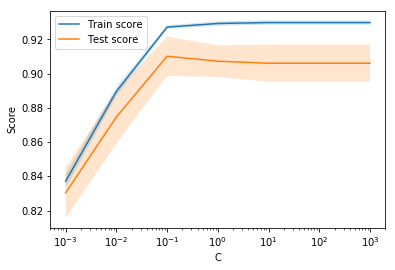

In [37]:
results.plot('param_C', 'mean_train_score', label='Train score')
results.plot('param_C', 'mean_test_score', label='Test score', ax=plt.gca())
plt.fill_between(results.param_C.astype(np.float),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], 
                 alpha=0.2)
plt.fill_between(results.param_C.astype(np.float),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], 
                 alpha=0.2)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Score')
plt.legend()
plt.show()

### 3.4 Precision-recall curve

In [47]:
y_score = clf.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score)
precision, recall, _ = precision_recall_curve(y_test, y_score)

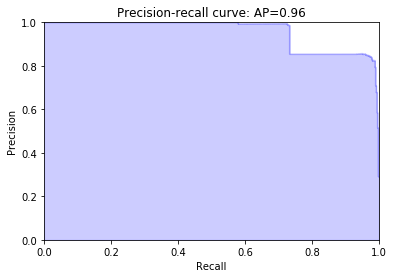

In [55]:
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision-recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

### 3.5 Evaluation of test set

In [50]:
y_true, y_pred = y_test, clf.predict(X_test)

In [51]:
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

        0.0       0.99      0.94      0.97      1637
        1.0       0.84      0.98      0.90       514

avg / total       0.96      0.95      0.95      2151



In [52]:
print("Training accuracy: {0:.3}".format(clf.score(X_train, y_train)))

Training accuracy: 0.927


In [53]:
print("Test accuracy: {0:.3}".format(clf.score(X_test, y_test)))

Test accuracy: 0.905


### 3.6 Top predictors of spam

Clearly there is an issue of our model picking up words that are specific to this data set. `spamassassinsight` seems to be referring to `spamassassin-sightings`, an e-mail list that some users refer to. `deathtospamdeathtospamdeathtospam` comes from someone's signature. If we were to generalize our model, we would need a more general vocabulary list, drawn from a more diverse data set.

In [54]:
# Sort the weights (coefficients) in *ascending* order
sorted_coef = np.argsort(clf.best_estimator_.coef_)[0]
# Find out the top predictors using the index of the weights
df_vocab = joblib.load('df_vocab.gz')
df_vocab.iloc[sorted_coef[-1:-10:-1]]

,0
108,click
1593,spamassassinsight
54,our
134,remov
37,will
1684,deathtospamdeathtospamdeathtospam
459,guarante
198,price
396,visit
